- Goal
    - Create synthetic data using IDM
    - Learn parameters of that data using particle filtering
    - Aliter 7 Feb: Learn using CEM idea, fitness function and then distb and then sample
- Learning
    - Need at least 2 vehicles so that there is a neighbor in the front
    - Otherwise src/1d/driver/lane_follower_driver errors
    - That is why the `AutomotiveDrivingModels/doc/1DMobius` stuff does 
    not work with 1 car only (needs at least 2 cars)
    - The tutorial does not work with `gen_straight_roadway` because that
    generates a roadway of type AutomotiveDrivingModels.roadway as opposed to
    AutomotiveDrivingModels.StraightRoadway
- Open question
    - IDM won't work unless there is a car in front (errors saynig nothing in sight)
    - We are focusing on learning the params of the second car here. Is that sound sensible?
- Flow of code
    - Call the required `usings`
    - Define functions required
    - Actual running things
        - Generate true trajectory
        - Generate a set of particles uniformly between sensible range of values
        - Compute fitness, sort and select numtop
        - Fit a distribution over this
        - Resample particles
- Scenario
    - Slower car in front (car 1)
    - Faster car behind (car 2)
    - We want to estimate params of car 2
- Feb 10: Adding timegap_des as our 2nd param in the 2 car, 1D, IDM scenario
    - Make code capable of handling 2d param. So far, had only scalar param
    i.e v_des
    - Fitting 2D distributions is required now

In [2]:
using AutomotiveDrivingModels
using AutoViz
using Reel
using Interact
using StatsBase # For random particle generation

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/5dc1e185f8b2175037a0bb4bac5baa1c8ca39ea5-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/5dc1e185f8b2175037a0bb4bac5baa1c8ca39ea5-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [ ]:
# Test: Generate samples for a 2d distb
d2 = MvNormal(2,2.0) # first arg shows dimension, second shows std dev
qw = rand(d2,6) # Will generate 6 samples i.e. 6 columns

In [ ]:
# Test: Fit 2d distribution
dx = Normal()
dy = Normal(2,1.0)
x = rand(dx,100)
y = rand(dy,100)

# Matrix with each column being a sample
# Total columns is total number of samples
# Total rows is number of parameters
# All entries in a row contain value from same param eg:v_des
data_matrix = vcat(x',y')
fit(MvNormal,data_matrix)

In [94]:
# Find the logpdf of a point under a distribution
t = Normal(1,1)
pdf(t,1.0)

0.3989422804014327

In [3]:
# 1 lane, 1000 m roadway
# roadway = gen_straight_roadway(1,1000.0) # Does not work with the below because AutomotiveDrivingModels.Roadway
roadway = StraightRoadway(1000.0); # AutomotiveDrivingModels.StraightRoadway type

In [122]:
# Function: Initialize the scene
    # Note: Vehicle def 1 (leader) is the one we learn params for
    # This is hard-coded in the gen_traj method by accessing first elem of scene vector
function init_scene(pos1=50.0,vel1=12.0,pos2=10.0,vel2=10.0)
    scene = Scene1D()
    
    # First arg to State1D is pos, 2nd arg is velocity
    push!(scene, Entity(State1D(pos1, vel1), VehicleDef(), 1))
    push!(scene, Entity(State1D(pos2, vel2), VehicleDef(), 2))
    return scene
end

init_scene (generic function with 5 methods)

In [130]:
# Function: Generate trajectory
    # Returns: array of positions over time
    # Other functions called: init_scene
    # How to call: hallucinated_traj = gen_traj(proposed_param)
    # Caution: Params is a 2 elem array for now with v_des and s_min as elems
function gen_traj(particle;nticks=100,timestep=0.1)
    scene = init_scene()
    models = Dict{Int, LaneFollowingDriver}()
    models[1] = IntelligentDriverModel(v_des=particle[1],σ = particle[2])
    models[2] = IntelligentDriverModel(v_des=12.0)

    # Simulate for nticks (default 100) time steps
    timestep = 0.1
    rec = QueueRecord(Vehicle1D, nticks+1, timestep)
    simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)

    # Extract the position and velocity of nticks timesteps
    # X stores this as 2d array. Timestep is the row, col 1 is pos,vel is pos2
    n_cars = scene.n
    n_ticks = nticks
    X = Array{Float64}(n_ticks, 1)

    for t in 1:n_ticks
        f = rec.frames[n_ticks - t + 1]
        
        # BAD: 2 cars in scene therefore loop has only 1 elem
        for c in 1:1 #Was 2:scene.n earlier
            s = f.entities[c].state
            X[t, 1] = s.s #position
        end
    end
    return X
end

gen_traj (generic function with 1 method)

$\sum_{t=1}^{t=end}\mid truePos_t - hallucinatedPos_t \mid$

In [98]:
# Function: Calculate abs pos error at every timestep
#    Some up those errors to create an error over entire traj
function calc_traj_error(traj1,traj2)
    return sum(abs.(traj1-traj2))
end

calc_traj_error (generic function with 1 method)

In [264]:
# Likelihood computation
    # NO CALIBRATION TO MAKE HALLUC MATCH GROUNDTRUTH AT EVERY TIMESTEP
    # Simple computing likelihood every timestep
    # Add log likelihood over all the timesteps

# TODO
    # What should be the variance of the Normal distb
    # Is adding without recalibrating to ground alright?

# Example of calling this function
#     duration = 100
#     true_traj = gen_traj([20.0 0.5],nticks=duration)
#     halluc_traj = gen_traj([20.0 1.0],nticks=duration)
#     calc_traj_loglikelihood(true_traj,halluc_traj)

function calc_traj_loglikelihood(true_traj,halluc_traj)
    assert(length(true_traj)==length(halluc_traj))
    duration = length(true_traj)
    ll = 0
    for i in 1:duration

        ll += logpdf(Normal(true_traj[i],1.0),halluc_traj[i])
    end
    return ll
end

calc_traj_loglikelihood (generic function with 1 method)

In [181]:
true_traj = gen_traj([20.0 0.5])
halluc_traj = gen_traj([20.0 1.0])
@show true_traj
calc_traj_loglikelihood(true_traj,halluc_traj)

true_traj = [51.2094; 52.4378; 53.6866; 54.9575; 56.2531; 57.5754; 58.9241; 60.3006; 61.7029; 63.1205; 64.5533; 66.0135; 67.5051; 69.0186; 70.5512; 72.1029; 73.6718; 75.2612; 76.8692; 78.4958; 80.1466; 81.8172; 83.5044; 85.2062; 86.9176; 88.6396; 90.3733; 92.1124; 93.858; 95.6156; 97.3815; 99.1581; 100.95; 102.756; 104.574; 106.404; 108.243; 110.09; 111.946; 113.811; 115.687; 117.572; 119.466; 121.368; 123.271; 125.174; 127.084; 129.001; 130.924; 132.855; 134.797; 136.748; 138.706; 140.67; 142.628; 144.578; 146.529; 148.482; 150.436; 152.395; 154.358; 156.325; 158.294; 160.265; 162.24; 164.217; 166.198; 168.182; 170.164; 172.145; 174.125; 176.1; 178.067; 180.032; 181.995; 183.952; 185.905; 187.857; 189.815; 191.78; 193.751; 195.728; 197.709; 199.695; 201.684; 203.669; 205.651; 207.635; 209.626; 211.615; 213.598; 215.581; 217.562; 219.54; 221.516; 223.493; 225.472; 227.448; 229.421; 231.393]


-229.1034947024176

In [265]:
# Function: Run an iteration i.e. take a set of particles and return a new set
    # numtop is the number of elites you want to select
# TODO: MAYBE DOING THIS IN PLACE WILL BE MORE EFFICIENT RATHER THAN RETURN WHOLE MATRIX
function new_p_from_old(particle_matrix,num_p,true_traj;numtop=15)
    # Input is a matrix with every column a different particle
    # Check that number of columns is same as number of particles
    assert(size(particle_matrix)[2]==num_p)
    
    # Loop over the particles (i.e. columns) and calculate traj_error
    p_traj_error = Array{Float64}(num_p)
    
    
    for i in 1:num_p
        proposed_traj = gen_traj(particle_matrix[:,i])
        p_traj_error[i] = calc_traj_loglikelihood(true_traj,proposed_traj)
    end

    # We don't care about the actual error values
    # We just care about the numtop of them

    # Sort the traj such that highest likelihood is at the top
        # rev=true does this for us i.e sort in decreasing order
    sortedidx = sortperm(p_traj_error,rev=true)
    
    # Select the numtop from the original particles
    best_particles = particle_matrix[:,sortedidx[1:numtop]]
#     @show "sortedNselectedtop"
    # Use the numtop particles to fit a Gaussian
#     @show best_particles
    p_distribution = fit(MvNormal,best_particles)
    @show p_distribution

    # Sample num_p new particles from this fitted distb
    new_p_matrix = rand(p_distribution,num_p)
#     @show new_p_matrix
    return new_p_matrix
end

new_p_from_old (generic function with 3 methods)

In [268]:
# Generate particles
num_p = 1000
# start:step:end and number of particles are the inputs to sample
v_particles = sample(10.0:1.0:40.0,num_p)
sig_particles = sample(0.0:0.1:2.0,num_p)

# Arrange the particles as follows
    # Every column is a different particle
    # Row 1 has v_des and row 2 has sigma
# init_particles = Array{Float64}(2,num_p)
# init_particles[1,:] = v_particles
# init_particles[2,:] = sig_particles
init_particles = vcat(v_particles',sig_particles')
# @show init_particles
distb = fit(MvNormal,init_particles)
@show distb

# Generate ground truth trajectory
ground_traj = gen_traj([20.0 0.5])

# Generate new particles
p_old = init_particles
# @show p_old
for i in 1:20
    @show i
    p_new = new_p_from_old(p_old,num_p,ground_traj,numtop=200)
    p_old = p_new
end

distb = FullNormal(
dim: 2
μ: [25.206, 0.9595]
Σ: [77.1436 0.439643; 0.439643 0.33879]
)

i = 1
p_distribution = FullNormal(
dim: 2
μ: [20.755, 0.946]
Σ: [3.30498 0.12877; 0.12877 0.327284]
)

i = 2
p_distribution = FullNormal(
dim: 2
μ: [20.2653, 0.857088]
Σ: [0.228903 -0.0108331; -0.0108331 0.328017]
)

i = 3
p_distribution = FullNormal(
dim: 2
μ: [20.1894, 0.680928]
Σ: [0.0433486 -0.00630615; -0.00630615 0.29221]
)

i = 4
p_distribution = FullNormal(
dim: 2
μ: [20.1758, 0.387435]
Σ: [0.014252 -0.0116263; -0.0116263 0.267173]
)

i = 5
p_distribution = FullNormal(
dim: 2
μ: [20.1944, 0.104731]
Σ: [0.00483284 -0.0127543; -0.0127543 0.171162]
)

i = 6
p_distribution = FullNormal(
dim: 2
μ: [20.1993, 0.00671874]
Σ: [0.00214765 -0.0100313; -0.0100313 0.131828]
)

i = 7
p_distribution = FullNormal(
dim: 2
μ: [20.2037, -0.00385448]
Σ: [0.00108549 -0.00601409; -0.00601409 0.0826565]
)

i = 8
p_distribution = FullNormal(
dim: 2
μ: [20.2033, 0.0301477]
Σ: [0.000764941 -0.00566668; -0.00566668 

# Visualize

In [176]:
# Function: Return rec corresponding to generated traj
    # Will help visualizatoin
    # Calls init_scene
# Might be useful later
    # models[2] = IntelligentDriverModel(v_des=particle[1],s_min=particle[2],T=particle[3])
function gen_rec4vid(particle;nticks=100,timestep=0.1)
    scene = init_scene()
    models = Dict{Int, LaneFollowingDriver}()
    models[1] = IntelligentDriverModel(v_des=particle[1],σ = particle[2])
    models[2] = IntelligentDriverModel(v_des=12.0)

    # Simulate for nticks (default 100) time steps
    timestep = 0.1
    rec = QueueRecord(Vehicle1D, nticks+1, timestep)
    simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)

    return rec
end

gen_rec4vid (generic function with 1 method)

(div
  Widgets.Widget{:slider}(DataStructures.OrderedDict{Symbol,Any}(:changes=>Observables.Observable{Int64}("ob_80", 0, Any[WebIO.SyncCallback(WebIO.Scope("knockout-component-f71dd8dd-5f9d-4223-898f-54b2893efa79", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["frame_index"], Dict{Symbol,Any}(Pair{Symbol,Any}(:className, "interact "),Pair{Symbol,Any}(:style, Dict{Any,Any}(Pair{Any,Any}(:padding, "5px 10px 0px 10px")))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"text-align:right;width:18%"))), 2), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:max, 101),Pair{Symbol,Any}(:min, 1),Pair{Symbol,Any}(:attributes, Dict{Any,Any}(Pair{Any,Any}(:type, "range"),Pair{Any,Any}(Symbol("data-bind"), "numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}"))),Pair{Symbol,Any}(:step, 1),Pair{Symbol,Any}(:className, "slider slider is-fullwidth"),Pair{Symbol,Any}(:style, Dict{Any,Any}())), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"flex-grow:1; margin: 0 2%"))), 1), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("data-bind"=>"text: displayedvalue"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"width:18%"))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"display:flex; justify-content:center; align-items:center;"))), 7), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("changes", (Observables.Observable{Int64}(#= circular reference @-7 =#), nothing)),Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("value", (Observables.Observable{Int64}("ob_79", 51, Any[WebIO.SyncCallback(WebIO.Scope(#= circular reference @-7 =#), WebIO.SyncCallback(WebIO.Scope(#= circular reference @-8 =#), WebIO.#37)), Observables.g]), nothing))), Set{String}(), nothing, Any["knockout"=>"/home/raunak/.julia/v0.6/Knockout/src/../assets/knockout.js", "knockout_punches"=>"/home/raunak/.julia/v0.6/Knockout/src/../assets/knockout_punches.js", "/home/raunak/.julia/v0.6/InteractBase/src/../assets/all.js", "/home/raunak/.julia/v0.6/InteractBase/src/../assets/style.css", "/home/raunak/.julia/v0.6/InteractBulma/src/../assets/main.css"], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":51}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        [this[\"displayedvalue\"]=ko.computed(function () {retu
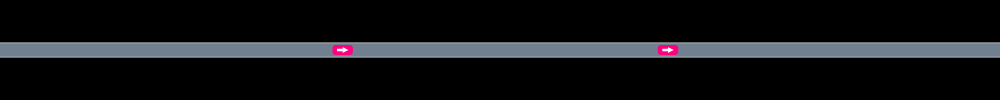
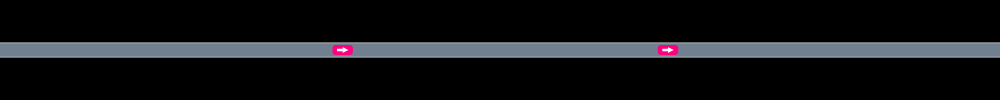

In [178]:
# overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true,
#         pos=VecE2(veh.state.s-0.7, 3)) for veh in scene];
# render(scene, roadway, overlays, cam=cam, canvas_height=100)

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
true_rec = gen_rec4vid([20.0 1.0],nticks=100)
rec = true_rec
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, cam=cam, canvas_height=100)
end

# 2D experimentation

In [ ]:
roadway = gen_straight_roadway(2,1000.0);

In [ ]:
scene = Scene1D()
push!(scene, Entity(State1D(10.0,  8.0), VehicleDef(), 1))
push!(scene, Entity(State1D(50.0, 12.5), VehicleDef(), 2))

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, pos=VecE2(veh.state.s-0.7, 3)) for veh in scene]
render(scene, roadway, overlays, cam=cam, canvas_height=100)

In [ ]:
models = Dict{Int64, DriverModel}()
models[1] = Tim2DDriver(0.1) # always produce zero acceleration
models[2] = Tim2DDriver(0.1) # default IDM with a desired speed of 12 m/s

nticks = 100
timestep = 0.1
rec = QueueRecord(Vehicle1D, nticks+1, timestep)
simulate!(rec, scene, roadway, models, nticks)